# Imports

In [38]:
import os
import sys
import h5py
import time
import youtube_dl

import numpy as np
import pandas as pd

import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import YouTubeVideo, Markdown, display, Video, Image

from tqdm.notebook import tqdm
tqdm.pandas()

In [39]:
pd.set_option('display.max_colwidth', 100)
pd.options.display.float_format = '{:,.2f}'.format
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [40]:
import sys
sys.path.append('/home/stav/Projects/token_voken')

In [5]:
from src.common.constants import PATS_DATA_ROOT

In [6]:
print(PATS_DATA_ROOT)
!ls -alh {PATS_DATA_ROOT}

/home/stav/Data/PATS_DATA
total 25M
drwxrwxr-x 3 stav stav 4.0K Sep  2 23:27 .
drwxrwxr-x 5 stav stav 4.0K Jul 26 02:57 ..
-rw-r--r-- 1 stav stav 8.1K Jul 19 22:32 .DS_Store
-rw-r--r-- 1 stav stav 4.0K Jun 28 20:37 ._.DS_Store
drwxrwxr-x 3 stav stav 4.0K Jun 28 20:37 Videos
-rw-r--r-- 1 stav stav  25M Sep  2 23:29 df_intervals_all.csv


# Constants

In [16]:
SPEAKER_NAME = 'noah'
INTERVALS_PATH = os.path.join(PATS_DATA_ROOT, 'df_intervals_all.csv')

In [23]:
COL_SPEAKER       = 'speaker'
COL_VIDEO_LINK    = 'video_link'
COL_VALID         = 'valid'

COLS = [COL_SPEAKER, COL_VIDEO_LINK, 'video_fn', 'start_time_string', 'end_time_string', 'delta_time', 'interval_id', 'speaker',
         'video_id', COL_VALID]

COLS_VALIDITY = [
    'valid',
    'valid_max_frames_per_token',
    'valid_duration',
    'valid_single_token_per_frame'
]
COLS_VIEW = [
    'speaker', 'interval_id',
    'duration', 'start_time_string', 'end_time_string',
    'video_link'
]

## Load Intervals

In [43]:
print(f'Loading {INTERVALS_PATH}..')
df_intervals_all = pd.read_csv(INTERVALS_PATH)
df_intervals_all.columns

Loading /home/stav/Data/PATS_DATA/df_intervals_all.csv..


Index(['Unnamed: 0', 'Unnamed: 0.1', 'dataset', 'delta_time', 'end_time',
       'interval_id', 'speaker', 'start_time', 'video_fn', 'video_link',
       'org_start_time', 'org_end_time', 'start_time_string',
       'end_time_string', 'video_id', 'max_frames_token', 'valid',
       'valid_max_frames_per_token', 'valid_duration',
       'valid_single_token_per_frame', 'video_downloded'],
      dtype='object')

In [20]:
df_intervals_all[COLS].sample(n=5)

,speaker,video_link,video_fn,start_time_string,end_time_string,delta_time,interval_id,speaker,video_id,valid
42661,jon,http://media.mtvnservices.com/embed/mgid:arc:video:comedycentral.com:39a96e12-4063-4015-bca8-7ac...,thedailyshow wait-wait----don-t-tell-him- part 1-39a96e12-4063-4015-bca8-7ac589fcd16f.mp4,00:01:17.1,00:01:29.48,12.48,211286,jon,ac589fcd16f,False
57411,shelly,http://www.youtube.com/watch?v=yJVpJ588ASc,16._Dying_alone_The_badness_of_death_Part_I-yJVpJ588ASc.mp4,00:16:45.33,00:16:55.88,10.54,2084,shelly,yJVpJ588ASc,False
63972,fallon,https://www.youtube.com/watch?v=tk67gfdyhLg,tk67gfdyhLg,00:03:17.53,00:03:40.3,22.50,cmu0000005766,fallon,tk67gfdyhLg,False
32610,ellen,https://www.youtube.com/watch?v=4-8LW2Zps1o,season12_Ellen_s_Advice_for_College_Grads-4-8LW2Zps1o.mkv,00:01:49.24,00:01:52.44,3.20,110690,ellen,4-8LW2Zps1o,False
1120,almaram,http://www.youtube.com/watch?v=0l0p1x7uffI,Lessons_in_Fiqh_52-0l0p1x7uffI.mp4,00:13:06.58,00:13:26.47,19.89,120353,almaram,0l0p1x7uffI,False


In [21]:
df_intervals_all[COLS].sample(n=5)

,speaker,video_link,video_fn,start_time_string,end_time_string,delta_time,interval_id,speaker,video_id,valid
70960,corden,https://www.youtube.com/watch?v=93kYLSAWQZw,93kYLSAWQZw,00:02:40.26,00:03:18.56,38.30,cmu0000018022,corden,93kYLSAWQZw,False
68310,colbert,https://www.youtube.com/watch?v=XGbw372nK-I,XGbw372nK-I,00:00:00.6,00:00:21.3,20.97,cmu0000013658,colbert,XGbw372nK-I,False
71548,corden,https://www.youtube.com/watch?v=lrTW3ujB7wI,lrTW3ujB7wI,00:00:24.29,00:00:30.66,6.37,cmu0000018900,corden,lrTW3ujB7wI,False
19647,angelica,http://www.youtube.com/watch?v=rIB_xuCbGK0,Mother_Angelica_Live_Classics_-_Thanksgiving_-_November_25_1992-rIB_xuCbGK0.mkv,00:05:50.38,00:05:54.85,4.47,65617,angelica,rIB_xuCbGK0,False
28833,conan,http://www.youtube.com/watch?v=rULPBI9O8d4,Monologue_03_19_12_-_CONAN_on_TBS-rULPBI9O8d4.mkv,00:00:47.56,00:01:13.3,25.47,114111,conan,rULPBI9O8d4,False


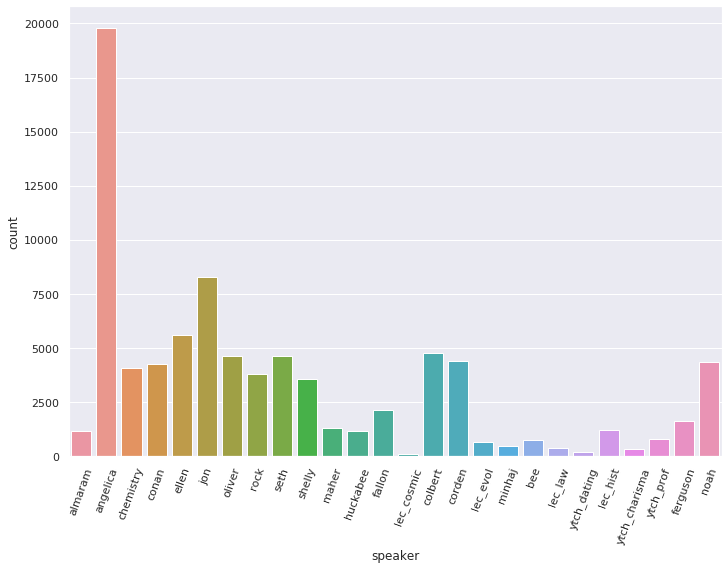

In [11]:
sns.countplot(data=df_intervals, x=COL_SPEAKER)
plt.xticks(rotation=70);

In [13]:
df_intervals.groupby(COL_SPEAKER)['delta_time'].sum().nlargest(30).to_frame()#.sort_values()

,delta_time
speaker,
angelica,"109,164.26"
noah,"101,010.67"
colbert,"84,448.37"
corden,"78,104.37"
seth,"74,028.03"
oliver,"65,723.10"
jon,"59,613.41"
conan,"59,600.71"
shelly,"43,058.79"


In [25]:
df_intervals_all[COL_SPEAKER].value_counts().to_frame()

,speaker
angelica,19795
jon,8257
ellen,5605
colbert,4744
seth,4636
oliver,4629
corden,4408
noah,4367
conan,4266
chemistry,4083


In [26]:
MASK_SPEAKER = df_intervals_all['speaker'] == SPEAKER_NAME

In [27]:
df_intervals = df_intervals_all[MASK_SPEAKER]
df_intervals.sample(n=3)[COLS]

,speaker,video_link,video_fn,start_time_string,end_time_string,delta_time,interval_id,speaker,video_id,valid
84093,noah,https://www.youtube.com/watch?v=4APOXh9qzlw,4APOXh9qzlw,00:00:33.6,00:00:39.3,5.97,cmu0000042449,noah,4APOXh9qzlw,False
82728,noah,https://www.youtube.com/watch?v=8gIydF9jHWE,8gIydF9jHWE,00:03:49.63,00:04:19.9,29.47,cmu0000039548,noah,8gIydF9jHWE,False
82583,noah,https://www.youtube.com/watch?v=htT9g1uHO00,htT9g1uHO00,00:09:20.20,00:09:24.56,4.37,cmu0000039297,noah,htT9g1uHO00,False


In [28]:
df_intervals.sample(n=3)

,Unnamed: 0,Unnamed: 0.1,dataset,delta_time,end_time,interval_id,speaker,start_time,video_fn,video_link,...,org_end_time,start_time_string,end_time_string,video_id,max_frames_token,valid,valid_max_frames_per_token,valid_duration,valid_single_token_per_frame,video_downloded
82470,82470,82470,train,25.70,0 days 00:16:44.130000,cmu0000039077,noah,0 days 00:16:18.430000,EWGGuItX9gY,https://www.youtube.com/watch?v=EWGGuItX9gY,...,0 days 00:16:44.130000,00:16:18.43,00:16:44.13,EWGGuItX9gY,-1,False,False,True,True,False
82968,82968,82968,train,43.37,0 days 00:06:07.060000,cmu0000040143,noah,0 days 00:05:23.700000,UkdAusG0OUE,https://www.youtube.com/watch?v=UkdAusG0OUE,...,0 days 00:06:07.060000,00:05:23.70,00:06:07.6,UkdAusG0OUE,-1,False,False,True,True,False
82571,82571,82571,train,9.40,0 days 00:01:25.090000,cmu0000039270,noah,0 days 00:01:15.700000,w5zvsnlyBeU,https://www.youtube.com/watch?v=w5zvsnlyBeU,...,0 days 00:01:25.090000,00:01:15.70,00:01:25.9,w5zvsnlyBeU,-1,False,False,False,True,False


In [29]:
df_intervals.shape

(4367, 21)

In [24]:
def print_df_info(df):
    print(f'{LIST_BULLET}Videos: #{df["video_link"].nunique():,}')
    print(f'{LIST_BULLET}Intervals: #{df["interval_id"].nunique():,}')
    total_duration = df["duration"].sum()
    total_duration_string = time.strftime('%H hours, %M minutues, %S seconds', time.gmtime(total_duration))
    print(f'{LIST_BULLET}Total Duration: {total_duration_string} ({int(total_duration):,} seconds)')
    all_youtube = df_intervals['video_link'].str.contains('youtube').all()
    print(f'{LIST_BULLET}All are Youtube videos: {all_youtube}')

In [25]:
printmd(f'Speaker **{SPEAKER_NAME}**:')
print_df_info(df_intervals)

Speaker **oliver**:

  ◘ Videos: #124
  ◘ Intervals: #4,629
  ◘ Total Duration: 18 hours, 15 minutues, 23 seconds (65,723 seconds)
  ◘ All are Youtube videos: True


In [37]:
interval_text_status = []
interval_id_to_df_words = {}

for interval_id in tqdm(speaker_interval_ids):
    try:
        df_words = read_text(interval_id)
        interval_id_to_df_words[interval_id] = df_words
        has_text = True
    except ValueError as e:
        has_text = False
    interval_text_status.append([interval_id, has_text])

NameError: name 'speaker_interval_ids' is not defined

# Intervals Validity

## Interval PATS Text

### Has Groups (`valid_hd5`)

In [73]:
df_interval_text_status = pd.DataFrame(interval_text_status, columns=['interval_id', 'valid_hd5'])
df_intervals = df_intervals.merge(df_interval_text_status)
display_value_counts(df_intervals['valid_hd5'], 'Valid hd5 group')

,valid_hd5
True,4254
False,375


### Token Frames Duration (`valid_max_token_duration`)

In [31]:
FRAME_RATE = 15
MAX_SECONDS_PER_TOKEN = 4
MAX_FRAMES_THRESHOLD = FRAME_RATE * MAX_SECONDS_PER_TOKEN
print(f'Max allowed frames per token is: {MAX_FRAMES_THRESHOLD} frames (= {MAX_SECONDS_PER_TOKEN} seconds)')

Max allowed frames per token is: 60 frames (= 4 seconds)


In [36]:
UNKNOWN_MAX_FRAMES_PER_TOKEN = -1

def get_max_frames_number_for_token(interval_id):
    df_tokens = interval_id_to_df_words[interval_id]
    max_token_frames = df_tokens['frames_count'].max()
    return max_token_frames

In [33]:
df_intervals['max_frames_token'] = df_intervals['interval_id'].progress_apply(get_max_frames_number_for_token)

  0%|          | 0/4367 [00:00<?, ?it/s]

<ipython-input-33-994f458a10c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intervals['max_frames_token'] = df_intervals['interval_id'].progress_apply(get_max_frames_number_for_token)


In [35]:
df_intervals['max_frames_token'].value_counts()

-1    4367
Name: max_frames_token, dtype: int64

In [81]:
df_intervals.head(n=2)

,Unnamed: 0,Unnamed: 0.1,dataset,duration,end_time,interval_id,speaker,start_time,video_fn,video_link,...,start_time_string,end_time_string,video_id,max_frames_token,valid,valid_max_frames_per_token,valid_duration,valid_single_token_per_frame,video_downloded,valid_hd5
0,43180,43180,dev,12.21,0 days 00:01:10.830000,214428,oliver,0 days 00:00:58.620000,Abortion_Laws_-_Last_Week_Tonight_with_John_Oliver_HBO-DRauXXz6t0Y.webm,http://www.youtube.com/watch?v=DRauXXz6t0Y,...,00:00:58.62,00:01:10.83,DRauXXz6t0Y,88,False,False,False,True,False,True
1,43181,43181,dev,6.14,0 days 00:01:17.110000,214429,oliver,0 days 00:01:10.970000,Abortion_Laws_-_Last_Week_Tonight_with_John_Oliver_HBO-DRauXXz6t0Y.webm,http://www.youtube.com/watch?v=DRauXXz6t0Y,...,00:01:10.97,00:01:17.11,DRauXXz6t0Y,31,False,True,False,True,False,True


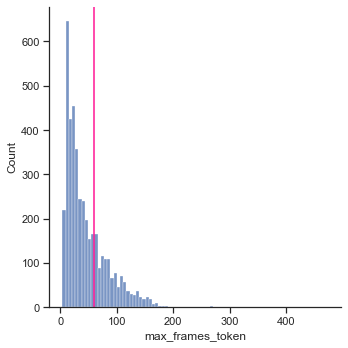

In [103]:
sns.set_style('ticks')
sns.displot(df_intervals[df_intervals['max_frames_token'] != -1]['max_frames_token'])
plt.axvline(MAX_FRAMES_THRESHOLD, color='deeppink');

In [105]:
mask_below_max_frames_limit = (df_intervals['max_frames_token'] < MAX_FRAMES_THRESHOLD)
mask_known_max_frames = (df_intervals['max_frames_token'] != UNKNOWN_MAX_FRAMES_PER_TOKEN) 

df_intervals['valid_max_token_duration'] = mask_below_max_frames_limit & mask_known_max_frames
display_value_counts(df_intervals['valid_max_token_duration'], 'Valid Token Duration')

,valid_max_token_duration
True,3077
False,1552


### Multiple Words Per Frame (`valid_single_token_per_frame`)

In [115]:
df_tokens = read_text('101204')
printmd(f'**Video path**: {resolve_interval_video_path("101204")}')
printmd(f'**Text path**: {resolve_interval_text_path("101204")}')
print(f'Start token unique: {df_tokens["start_frame"].is_unique}')
df_tokens[24:40]

**Video path**: /Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/5d667Bb_iYA/101204/101204.mp4

**Text path**: /Users/staveshemesh/Projects/PATS_DATA/Processed/oliver/data/processed/oliver/101204.h5

Start token unique: False


,Word,start_frame,end_frame,frames_count,time
24,out,117,120,3,8.00
25,me,120,123,3,8.20
26,on,123,123,0,8.20
27,so,123,127,4,8.50
28,too,127,130,3,8.70
29,should,130,136,6,9.10
30,gay,136,141,5,9.40
31,people,141,144,3,9.60
32,be,144,147,3,9.80
33,discriminated,147,147,0,9.80


In [120]:
MAX_TOKENS_PER_FRAME_LIMIT = 2 # allow not more two tokens with the same start frame

def valid_single_frame_tokens_count(interval_id):
    df_tokens = interval_id_to_df_words.get(interval_id)
    if df_tokens is None:
        return False
    max_tokens_per_frame = df_tokens['start_frame'].value_counts().max()
    return max_tokens_per_frame <= MAX_TOKENS_PER_FRAME_LIMIT

In [121]:
df_intervals['valid_single_token_per_frame'] = df_intervals['interval_id'].progress_apply(valid_single_frame_tokens_count)

In [122]:
display_value_counts(df_intervals['valid_single_token_per_frame'], f'Max of {MAX_TOKENS_PER_FRAME_LIMIT} tokens per frame')

,valid_single_token_per_frame
True,4062
False,567


### Frame Count (`valid_frames_count`)

In [140]:
def valid_interval_frame_count(interval_id, duration):
    df_tokens = interval_id_to_df_words.get(interval_id)
    if df_tokens is None:
        return False
    total_frames = df_tokens['end_frame'].max()
    max_tokens_per_frame = df_tokens['start_frame'].value_counts().max()
    lower_bound = (duration - 2) * FRAME_RATE
    upper_bound = (duration + 1) * FRAME_RATE
    is_valid = lower_bound <= total_frames <= upper_bound
    debug_symbol = '✓' if is_valid else '✗'
    if interval_id in df_intervals['interval_id'][:10].tolist():
        print(debug_symbol, interval_id, round(lower_bound, 2), total_frames, round(upper_bound, 2))
    return lower_bound <= total_frames <= upper_bound

In [141]:
df_intervals['valid_frames_count'] = df_intervals[['interval_id', 'duration']].progress_apply(lambda x: valid_interval_frame_count(*x), axis=1)

✓ 214428 153.18 184 198.18
✓ 214429 62.09 93 107.09
✗ 214430 1506.54 1482 1551.54
✓ 214431 73.1 104 118.1
✓ 214433 212.24 241 257.24
✓ 214434 368.4 396 413.4
✓ 214435 70.1 101 115.1
✓ 214436 61.09 92 106.09
✓ 214438 1164.19 1190 1209.19
✗ 214439 124.15 123 169.15



In [132]:
display_value_counts(df_intervals['valid_frames_count'], f'Frame Count = Frame Rate * Seconds')

,valid_frames_count
False,3916
True,713


In [137]:
read_text('214439')

,Word,start_frame,end_frame,frames_count,time
0,restrictions,0,8,8,0.50
1,on,8,8,0,0.50
2,Old,8,11,3,0.70
3,clinics,11,19,8,1.30
4,pictures,19,22,3,1.50
5,of,22,23,1,1.50
6,Kum,23,28,5,1.90
7,&,28,29,1,1.90
8,Go's,29,32,3,2.10
9,now,32,35,3,2.30


## Interval Video

### Total Duration (`valid_duration`)

In [170]:
MIN_DURATION_SECS_THRESHOLD = 4

In [171]:
df_intervals.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'dataset', 'duration', 'end_time',
       'interval_id', 'speaker', 'start_time', 'video_fn', 'video_link',
       'org_start_time', 'org_end_time', 'start_time_string',
       'end_time_string', 'video_id', 'max_frames_token', 'valid',
       'valid_duration', 'valid_single_token_per_frame', 'video_downloded',
       'valid_hd5', 'valid_max_token_duration', 'valid_frames_count'],
      dtype='object')

In [172]:
df_intervals['valid_duration'] = MIN_DURATION_SECS_THRESHOLD < df_intervals['duration']

In [173]:
display_value_counts(df_intervals['valid_duration'], f'Duration > {MIN_DURATION_SECS_THRESHOLD} seconds')

,valid_duration
True,3499
False,1130


## Finalize Valid

In [174]:
df_intervals.columns[df_intervals.columns.str.contains('valid_')].tolist()

['valid_duration',
 'valid_single_token_per_frame',
 'valid_hd5',
 'valid_max_token_duration',
 'valid_frames_count']

In [175]:
df_intervals.drop('valid_max_frames_per_token', axis=1, errors='ignore', inplace=True)

In [176]:
COLS_VALID = [
    'valid_duration',
    'valid_single_token_per_frame',
    'valid_hd5',
    'valid_max_token_duration',
    'valid_frames_count'
]

In [177]:
total_intervals = len(df_intervals)
df_validity_summary = df_intervals[COLS_VALID].sum().to_frame().rename(columns={0: 'records'})
df_validity_summary['%records'] = df_validity_summary['records'] / total_intervals * 100
df_validity_summary

,records,%records
valid_duration,3499,75.59
valid_single_token_per_frame,4062,87.75
valid_hd5,4254,91.90
valid_max_token_duration,3077,66.47
valid_frames_count,4076,88.05


In [184]:
df_intervals['valid'] = df_intervals[COLS_VALID].all(axis=1)
display_value_counts(df_intervals['valid'], 'Valid Intervals')

,valid
False,2511
True,2118


In [186]:
df_validity_summary = df_intervals[['valid'] + COLS_VALID].sum().to_frame().rename(columns={0: 'records'})
df_validity_summary['%records'] = df_validity_summary['records'] / total_intervals * 100
df_validity_summary

,records,%records
valid,2118,45.76
valid_duration,3499,75.59
valid_single_token_per_frame,4062,87.75
valid_hd5,4254,91.90
valid_max_token_duration,3077,66.47
valid_frames_count,4076,88.05


In [246]:
df_intervals[['valid'] + COLS_VIEW + COLS_VALID].head(n=2)

,valid,speaker,interval_id,duration,start_time_string,end_time_string,video_link,valid_duration,valid_single_token_per_frame,valid_hd5,valid_max_token_duration,valid_frames_count
0,False,oliver,214428,12.21,00:00:58.62,00:01:10.83,http://www.youtube.com/watch?v=DRauXXz6t0Y,True,True,True,False,True
1,True,oliver,214429,6.14,00:01:10.97,00:01:17.11,http://www.youtube.com/watch?v=DRauXXz6t0Y,True,True,True,True,True


# Download Data

In [194]:
os.makedirs(OUTPUT_DIR)

In [195]:
printmd(f'{TAB}**/{TIMESTR}** → mkdir {OUTPUT_DIR}..')

&nbsp;&nbsp;&nbsp;&nbsp;**/20210418_005318** → mkdir /Users/staveshemesh/Projects/shstav2/token_voken/data/20210418_005318/dataframes..

## df_intervals.to_csv

In [204]:
df_intervals.drop('Unnamed: 0.1', axis=1, inplace=True)

In [3]:
COLS_OUTPUT = [
    # core
    'speaker', 'video_id', 'interval_id', 'valid',
    # features
    'duration', 'start_time_string',  'end_time_string',
    'video_link', 'video_fn',
    'start_time', 'end_time',
    'org_start_time', 'org_end_time',
    # validity
    'max_frames_token',
    'valid_duration', 'valid_single_token_per_frame', 'video_downloded', 'valid_hd5',
    'valid_max_token_duration', 'valid_frames_count'
]

In [232]:
len(df_intervals.columns), len(COLS_OUTPUT)

(20, 20)

In [235]:
df_intervals = df_intervals[COLS_OUTPUT]
df_intervals.head(n=2)

,speaker,video_id,interval_id,valid,duration,start_time_string,end_time_string,video_link,video_fn,start_time,end_time,org_start_time,org_end_time,max_frames_token,valid_duration,valid_single_token_per_frame,video_downloded,valid_hd5,valid_max_token_duration,valid_frames_count
0,oliver,DRauXXz6t0Y,214428,False,12.21,00:00:58.62,00:01:10.83,http://www.youtube.com/watch?v=DRauXXz6t0Y,Abortion_Laws_-_Last_Week_Tonight_with_John_Oliver_HBO-DRauXXz6t0Y.webm,0 days 00:00:58.620000,0 days 00:01:10.830000,0 days 00:00:58.620000,0 days 00:01:10.830000,88,True,True,False,True,False,True
1,oliver,DRauXXz6t0Y,214429,True,6.14,00:01:10.97,00:01:17.11,http://www.youtube.com/watch?v=DRauXXz6t0Y,Abortion_Laws_-_Last_Week_Tonight_with_John_Oliver_HBO-DRauXXz6t0Y.webm,0 days 00:01:10.970000,0 days 00:01:17.110000,0 days 00:01:10.970000,0 days 00:01:17.110000,31,True,True,False,True,True,True


In [241]:
intervals_output_path = os.path.join(OUTPUT_DIR, f'df_intervals_{SPEAKER_NAME}.csv')
printmd(f'{TAB}**/{TIMESTR}** → df_intervals {intervals_output_path}')
df_intervals.to_csv(intervals_output_path, index=False, header=True)

&nbsp;&nbsp;&nbsp;&nbsp;**/20210418_005318** → df_intervals /Users/staveshemesh/Projects/shstav2/token_voken/data/20210418_005318/dataframes/df_intervals_oliver.csv